#**Content-Based Music Recommendation System**

This notebook walks through the process of building a content-based music recommendation system that suggests songs based on their characteristics, like tempo, genre energy and etc.


###Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
sb.set()

In [2]:
#load the dataset

spotify_dt = pd.read_csv('spotify_songs.csv')

In [3]:
spotify_dt.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


### Exploratory Data Analysis and Preprocessing


In [4]:
spotify_dt.shape

(32833, 23)

In [5]:
spotify_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

we have 32,833 tracks and 23 features, but we will do data cleaning and preprocessing before moving to model training, we will drop some columns and rows, as we can see we have columns containing different data types, we will take care of those in the preprocessing step as well.

In [6]:
#let's check the columns

spotify_dt.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [7]:
#drop the columns that might (I rely on my experience when saying this) useful for finding the most similar neighbors

spotify_dt.drop(columns = ['track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_subgenre', 'mode'],  axis=1, inplace=True )
spotify_dt.head()

#dropped playlist_subgenre because we have playlist_genre and both of them give the same info

,track_id,track_name,track_artist,track_popularity,playlist_genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,pop,0.748,0.916,6,-2.634,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,pop,0.726,0.815,11,-4.969,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,pop,0.675,0.931,1,-3.432,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,pop,0.718,0.930,7,-3.778,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,pop,0.650,0.833,1,-4.672,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [8]:
#let's check the # of null values

spotify_dt.isnull().sum()

,0
track_id,0
track_name,5
track_artist,5
track_popularity,0
playlist_genre,0
danceability,0
energy,0
key,0
loudness,0
speechiness,0


In [9]:
#we have few missing values, so we can just drop those

spotify_dt.dropna(inplace = True)

In [10]:
#let's double check if no nulls present

spotify_dt.isnull().any()

,0
track_id,False
track_name,False
track_artist,False
track_popularity,False
playlist_genre,False
danceability,False
energy,False
key,False
loudness,False
speechiness,False


In [12]:
#now turning to duplicates

print(spotify_dt.duplicated().sum())

2448


In [13]:
##we ended up with quite a decent number of duplicates supposedly because of dropping some of the cols earlier, no need to keep them, so we will just drop

spotify_dt.drop_duplicates(inplace=True)

In [15]:
print(spotify_dt.duplicated().sum())

#rechecked, good to go now

0


In [16]:
spotify_dt.shape

#so we ended up with 30k songs and 16 features

(30380, 16)

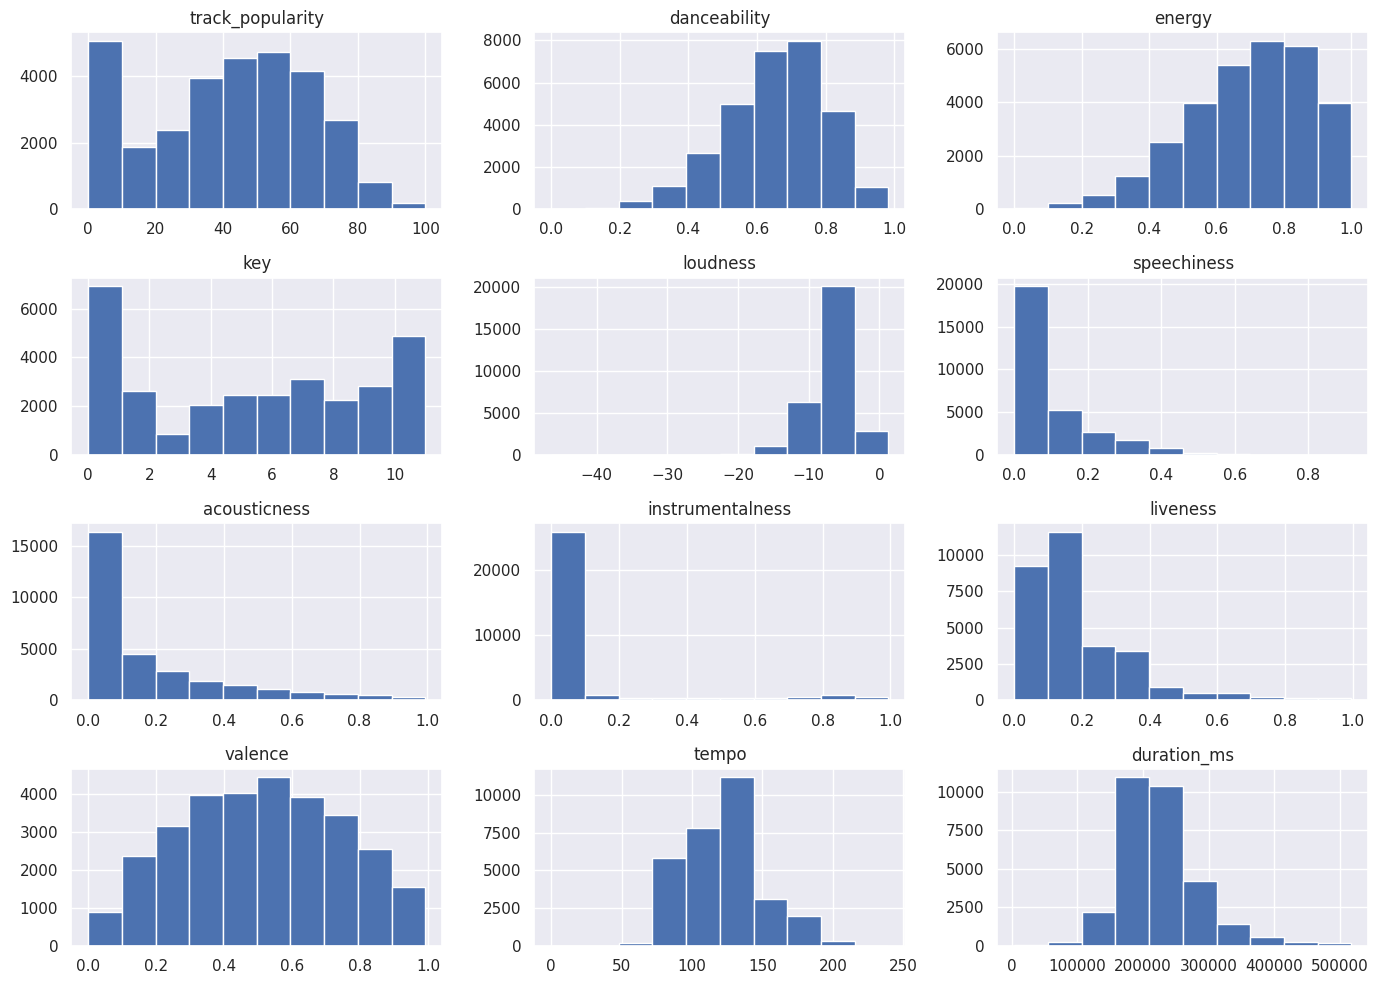

In [17]:
#let's see the distributions for numerical cols

spotify_dt.hist(figsize = (14,10))
plt.tight_layout()
plt.show()

From the histograms, we can see that some of the cols contain highly skewed data. Since we will be using NearestNeighbors and it is distance-based model, noticeable skewness can affect NN's performance, so we will have to apply some kind of transformation to have more or less normal distribution. Below, I have chosen features with highly skewed distributions.

In [18]:
features_dist = ['track_popularity', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'duration_ms']

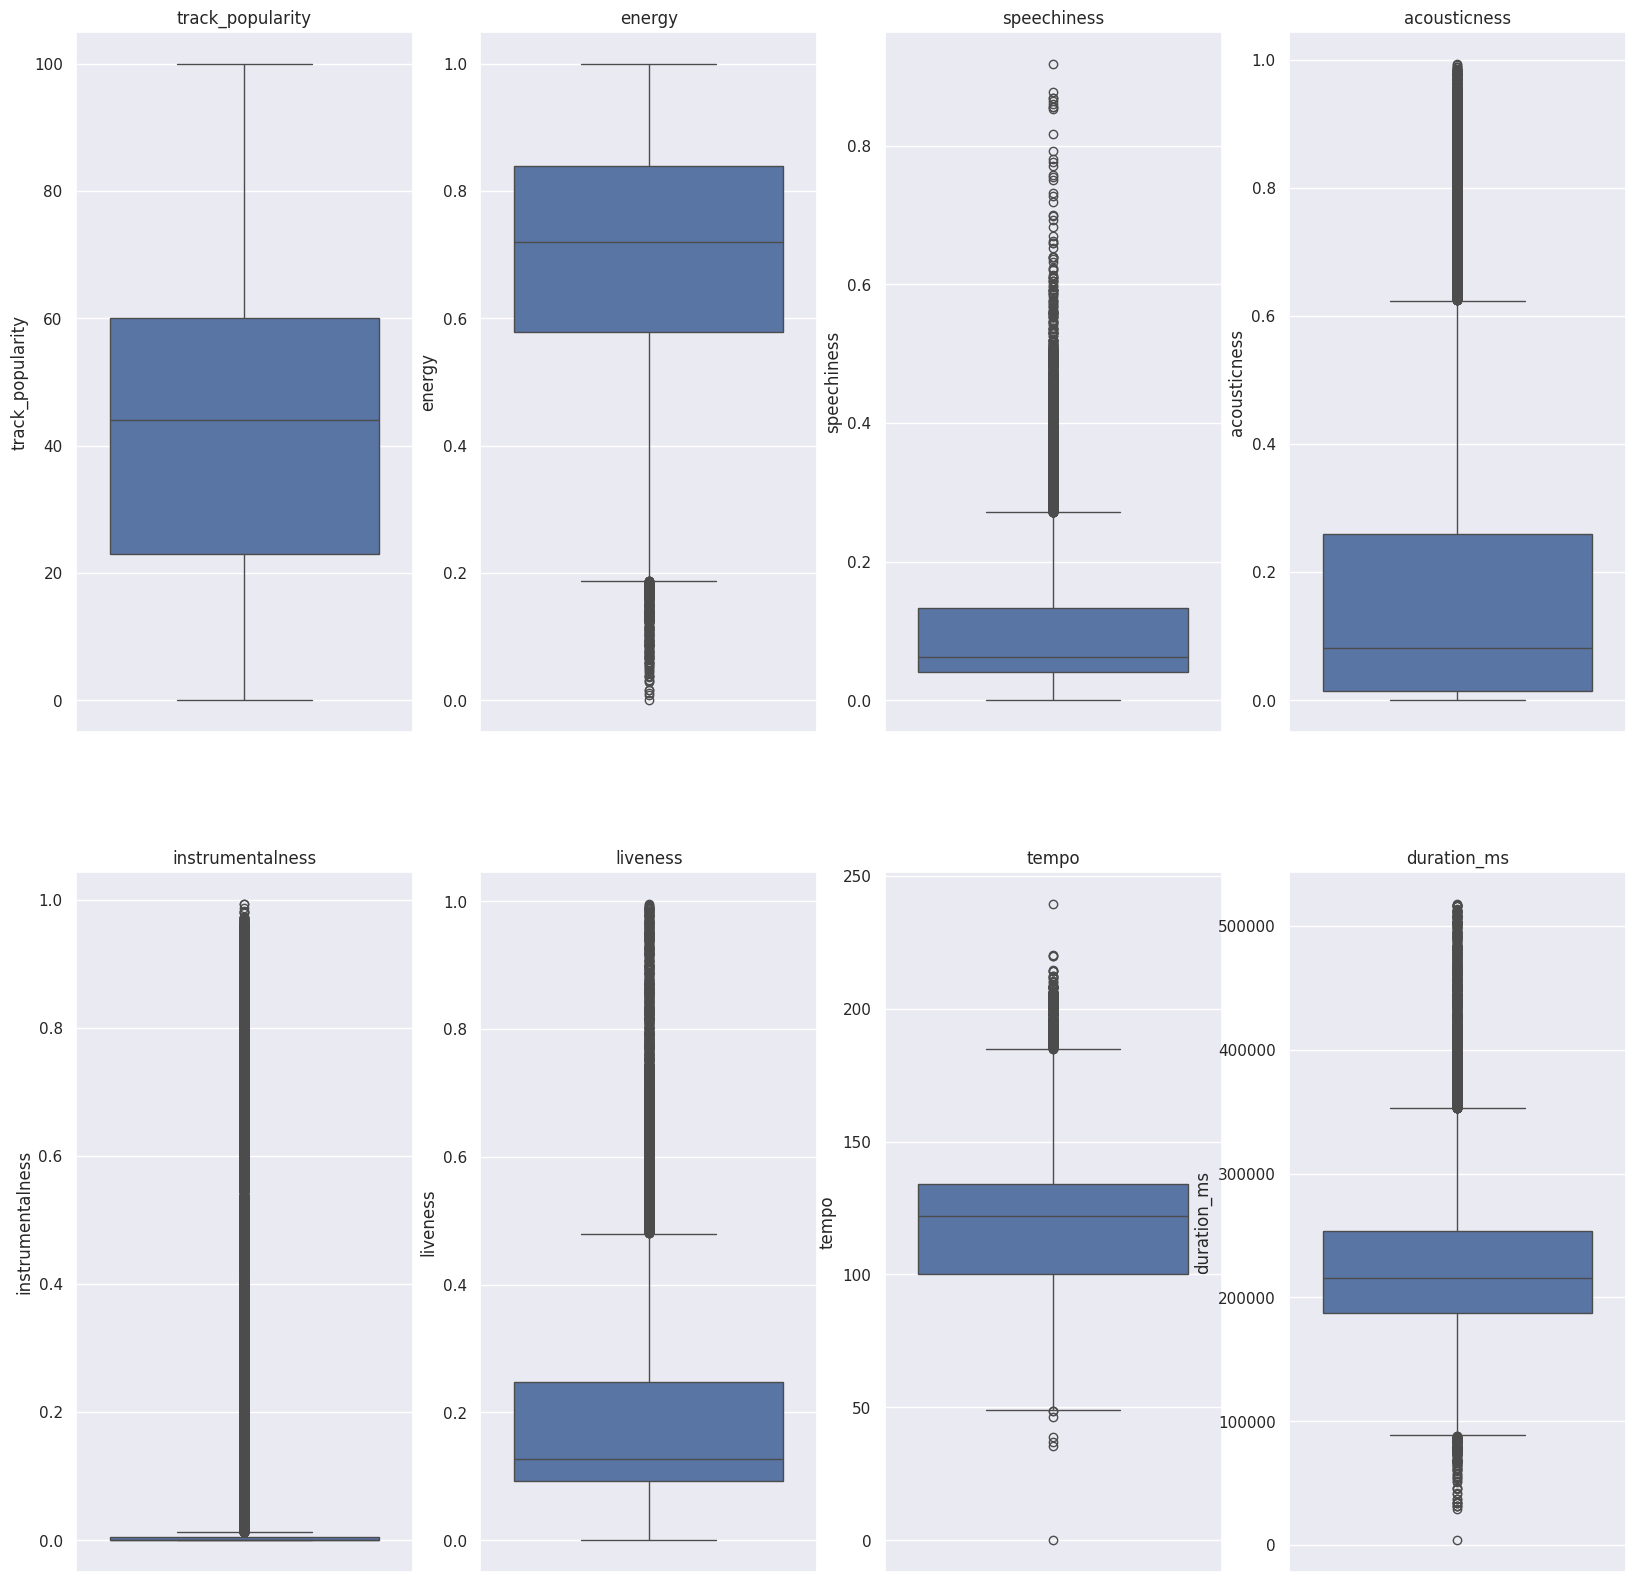

In [19]:
#now let's look closer at their distributions using box plots, histogram is not sometimes to make a decision

plt.figure(figsize=(20,20))
for i, feature in enumerate(features_dist, 1):
  plt.subplot(2, 4, i)
  sb.boxplot(y=spotify_dt[feature])
  plt.title(feature)

plt.show()

Based on the box plots, we can conclude that all of the columns except for track_popularity and tempo need some kind of transformation

In [20]:
spotify_dt[features_dist].describe()

#We don't have negative values, but we have 0s, so we need to take that into account when choosing a transformation technique

,track_popularity,energy,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms
count,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000
mean,41.010698,0.697151,0.107660,0.177620,0.087335,0.190103,120.886563,225739.539829
std,24.418562,0.181950,0.102077,0.222132,0.227941,0.154706,26.922194,60277.880519
min,0.000000,0.000175,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,23.000000,0.579000,0.041000,0.015100,0.000000,0.092700,99.973750,187524.750000
50%,44.000000,0.720000,0.062700,0.081200,0.000017,0.127000,121.963000,216000.000000
75%,60.000000,0.840000,0.133000,0.259000,0.005310,0.248000,133.976000,253609.750000
max,100.000000,1.000000,0.918000,0.994000,0.994000,0.996000,239.440000,517810.000000


In [21]:
#we have positively and negatively skewed data, that is why YEO-JOHNSON transformation will work best here

from sklearn.preprocessing import PowerTransformer

features_transform = ['energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']
transform = PowerTransformer(method='yeo-johnson')
spotify_dt[features_transform] = transform.fit_transform(spotify_dt[features_transform])
spotify_dt.head()

,track_id,track_name,track_artist,track_popularity,playlist_genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,pop,0.748,1.339405,6,-2.634,-0.390155,-0.032933,-0.508212,-1.238301,0.518,122.036,-0.455594
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,pop,0.726,0.611971,11,-4.969,-0.974408,-0.303841,-0.350750,1.386046,0.693,99.972,-1.123803
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,pop,0.675,1.455303,1,-3.432,-0.032918,-0.235981,-0.507314,-0.476565,0.613,124.008,-0.820243
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,pop,0.718,1.447511,7,-3.778,0.456392,-0.789381,-0.507849,0.560259,0.277,121.956,-0.980602
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,pop,0.650,0.735014,1,-4.672,-1.018685,-0.227434,-0.508212,-0.904063,0.725,123.976,-0.567098


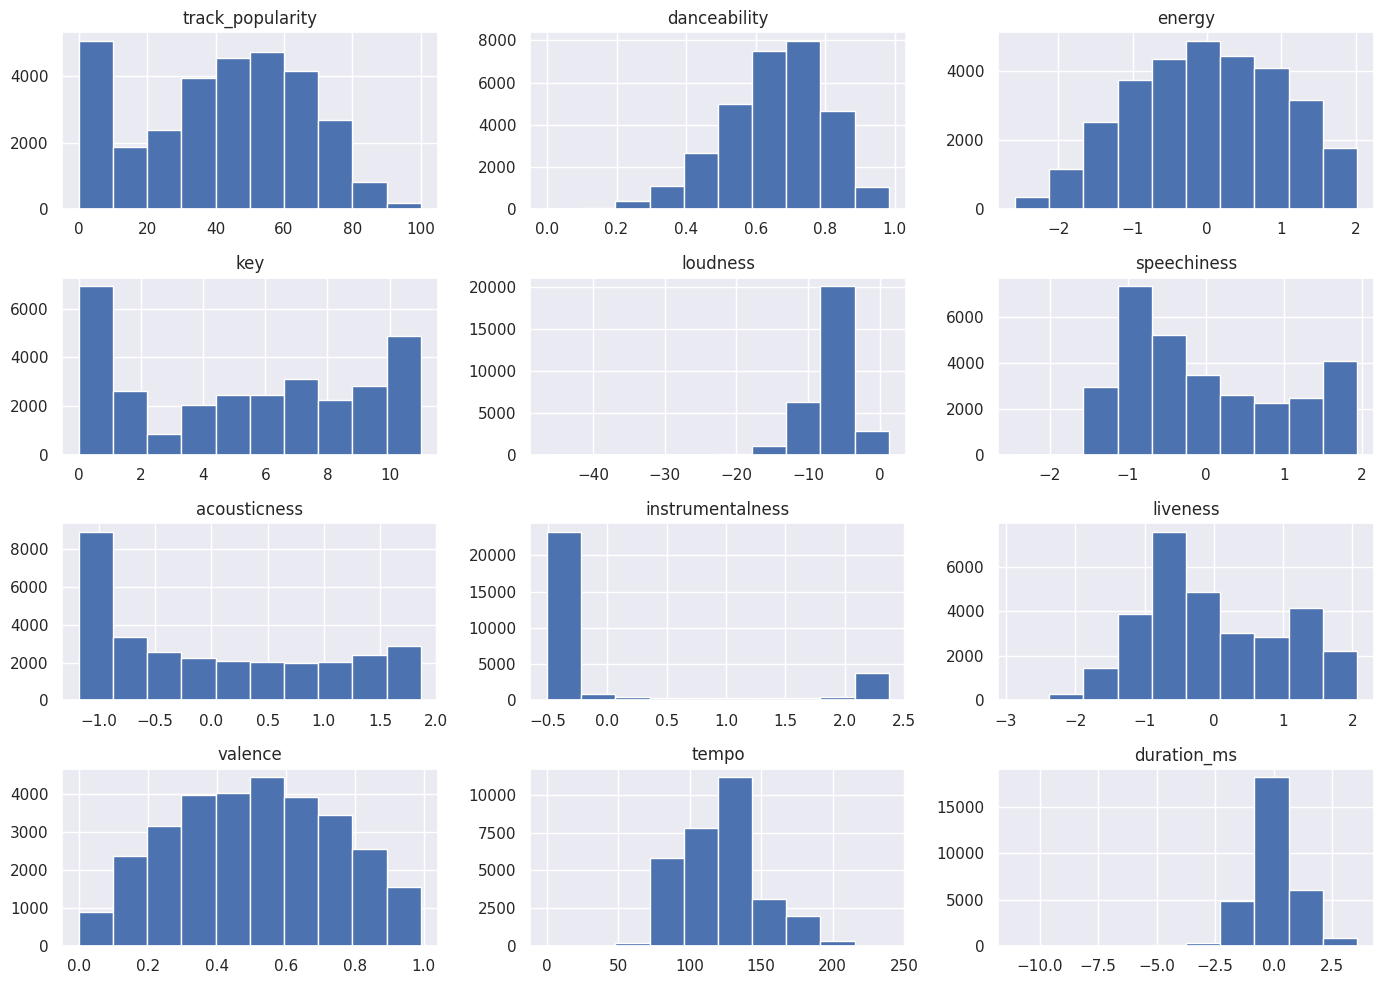

In [22]:
#let's see if anything changed

spotify_dt.hist(figsize=(14, 10))
plt.tight_layout()
plt.show()

Most of the transformed columns have the distribution we need, so we are good to go

In [23]:
#mostly done with numerical values, turning to columns of obj type, they need to be preprocessed too

obj_cols = spotify_dt.select_dtypes(include='object')
obj_cols

,track_id,track_name,track_artist,playlist_genre
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,pop
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,pop
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,pop
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,pop
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,pop
...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,edm
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,edm
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,edm
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,edm


In [24]:
#the only column that will be useful for model fitting is genre, (the rest will be used as unique identifiers) so let's see how many unique values genre col has

spotify_dt['playlist_genre'].nunique()

6

In [25]:
spotify_dt['playlist_genre'].unique()

#we will encode this using One hot encoder because they are nominal

array(['pop', 'rap', 'rock', 'latin', 'r&b', 'edm'], dtype=object)

In [26]:
#encoding genres into dummies

spotify_dt = pd.get_dummies(spotify_dt, columns=['playlist_genre'], prefix='genre')

In [27]:
spotify_dt.head()

,track_id,track_name,track_artist,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,0.748,1.339405,6,-2.634,-0.390155,-0.032933,...,-1.238301,0.518,122.036,-0.455594,False,False,True,False,False,False
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,0.726,0.611971,11,-4.969,-0.974408,-0.303841,...,1.386046,0.693,99.972,-1.123803,False,False,True,False,False,False
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,0.675,1.455303,1,-3.432,-0.032918,-0.235981,...,-0.476565,0.613,124.008,-0.820243,False,False,True,False,False,False
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,0.718,1.447511,7,-3.778,0.456392,-0.789381,...,0.560259,0.277,121.956,-0.980602,False,False,True,False,False,False
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,0.650,0.735014,1,-4.672,-1.018685,-0.227434,...,-0.904063,0.725,123.976,-0.567098,False,False,True,False,False,False


In [28]:
#converting True/False to 0s and 1s

genre_cols = ['genre_edm', 'genre_latin',	'genre_pop',	'genre_r&b', 'genre_rap',	'genre_rock']
spotify_dt[genre_cols] = spotify_dt[genre_cols].astype(int)
spotify_dt.head()

,track_id,track_name,track_artist,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,0.748,1.339405,6,-2.634,-0.390155,-0.032933,...,-1.238301,0.518,122.036,-0.455594,0,0,1,0,0,0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,0.726,0.611971,11,-4.969,-0.974408,-0.303841,...,1.386046,0.693,99.972,-1.123803,0,0,1,0,0,0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,0.675,1.455303,1,-3.432,-0.032918,-0.235981,...,-0.476565,0.613,124.008,-0.820243,0,0,1,0,0,0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,0.718,1.447511,7,-3.778,0.456392,-0.789381,...,0.560259,0.277,121.956,-0.980602,0,0,1,0,0,0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,0.650,0.735014,1,-4.672,-1.018685,-0.227434,...,-0.904063,0.725,123.976,-0.567098,0,0,1,0,0,0


In [29]:
#we ended up with 5 additional features after encoding

spotify_dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30380 entries, 0 to 32832
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          30380 non-null  object 
 1   track_name        30380 non-null  object 
 2   track_artist      30380 non-null  object 
 3   track_popularity  30380 non-null  int64  
 4   danceability      30380 non-null  float64
 5   energy            30380 non-null  float64
 6   key               30380 non-null  int64  
 7   loudness          30380 non-null  float64
 8   speechiness       30380 non-null  float64
 9   acousticness      30380 non-null  float64
 10  instrumentalness  30380 non-null  float64
 11  liveness          30380 non-null  float64
 12  valence           30380 non-null  float64
 13  tempo             30380 non-null  float64
 14  duration_ms       30380 non-null  float64
 15  genre_edm         30380 non-null  int64  
 16  genre_latin       30380 non-null  int64  
 17

In [30]:
#now the scaling should be done, so we need to decide which columns will be used for model fitting

num_cols = spotify_dt.select_dtypes(include = ['int', 'float'])
num_cols.columns

Index(['track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'genre_edm', 'genre_latin',
       'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock'],
      dtype='object')

In [31]:
#we need these columns for scaling

features = ['track_popularity',	'danceability',	'energy',	'key',	'loudness',	'speechiness',	'acousticness',	'instrumentalness',	'liveness',	'valence',	'tempo',	'duration_ms']

In [32]:
#we have normal distribution for most of the features, also we have cat. columns encoded as 0 or 1, so normalization is preferred in this case
#to make sure features are within the same range

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [33]:
spotify_dt[features] = scaler.fit_transform(spotify_dt[features])

In [34]:
spotify_dt

,track_id,track_name,track_artist,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,0.66,0.760936,0.852850,0.545455,0.918090,0.469476,0.376577,...,0.330351,0.522704,0.509673,0.725071,0,0,1,0,0,0
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,0.67,0.738555,0.694584,1.000000,0.869162,0.336105,0.287408,...,0.862526,0.699294,0.417524,0.679310,0,0,1,0,0,0
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,0.70,0.686673,0.878065,0.090909,0.901368,0.551025,0.309744,...,0.484819,0.618567,0.517908,0.700099,0,0,1,0,0,0
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,0.60,0.730417,0.876370,0.636364,0.894118,0.662723,0.127594,...,0.695070,0.279516,0.509338,0.689117,0,0,1,0,0,0
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,0.69,0.661241,0.721354,0.090909,0.875385,0.325997,0.312558,...,0.398129,0.731584,0.517775,0.717435,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32828,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,0.42,0.435402,0.862881,0.181818,0.935272,0.632550,0.300908,...,0.336319,0.211907,0.535291,0.737548,1,0,0,0,0,0
32829,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,0.20,0.531027,0.652724,0.000000,0.879785,0.368848,0.008185,...,0.874444,0.403633,0.534752,0.886707,1,0,0,0,0,0
32830,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,0.14,0.538149,0.703440,0.545455,0.870628,0.408751,0.393060,...,0.589556,0.439960,0.534535,0.744759,1,0,0,0,0,0
32831,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,0.15,0.636826,0.806984,0.181818,0.902856,0.685813,0.037262,...,0.852433,0.310797,0.534614,0.898114,1,0,0,0,0,0


In [35]:
spotify_dt.describe()

,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,genre_edm,genre_latin,genre_pop,genre_r&b,genre_rap,genre_rock
count,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000,30380.000000
mean,0.410107,0.666124,0.561439,0.488141,0.831426,0.558539,0.387417,0.176407,0.581458,0.514605,0.504872,0.756271,0.182258,0.152699,0.168927,0.169124,0.180481,0.146511
std,0.244186,0.147675,0.217571,0.328518,0.063010,0.228281,0.329154,0.347119,0.202787,0.235483,0.112438,0.068484,0.386063,0.359703,0.374694,0.374868,0.384594,0.353623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.230000,0.572737,0.396702,0.181818,0.800830,0.362032,0.069651,0.000000,0.430407,0.332997,0.417532,0.715357,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.440000,0.682604,0.563142,0.545455,0.842969,0.493546,0.315358,0.000230,0.532630,0.515641,0.509368,0.751993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.600000,0.774161,0.731930,0.818182,0.875134,0.752822,0.682497,0.068403,0.758945,0.699294,0.559539,0.794711,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


finished the preprocessing part now let's jump into modelling

###Applying NearestNeighbors and Building UI

We will have a simple UI based on Gradio

In [36]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.9 MB/s eta 0:00:00


In [37]:
import gradio as gr
from sklearn.neighbors import NearestNeighbors

In [38]:
#to make things easier, let's add a dropdown with a list of songs and also we will be able to choose distance metric for NN (default will be cosine in the dropdown)

song_dropdown = gr.Dropdown(
    choices=spotify_dt.apply(lambda x: f"{x['track_name']} by {x['track_artist']}", axis=1).tolist(),
    label="Select a Song")

metric_dropdown = gr.Dropdown(
    choices=['cosine', 'euclidean'],  #two options: Cosine and Euclidean
    label="Select Distance Metric",
    value='cosine')

In [39]:
#we will use the following features for comparing songs

feature_cols=spotify_dt.columns[3:]
feature_cols

Index(['track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'genre_edm', 'genre_latin',
       'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock'],
      dtype='object')

In [40]:
#the function where NN will actually be implemented

def recommend_songs(selected_song, distance_metric='cosine'):
    #extract song name and artist from the selected song string
    song_name, artist = selected_song.split(" by ") #used by as a delimeter

    #find the track_id for the selected song, I am not sure if track_name and track_artist are unique, that's why track_id is being used
    track_id = spotify_dt.loc[(spotify_dt['track_name'] == song_name) & (spotify_dt['track_artist'] == artist), 'track_id'].values[0]

    #extract features for an identified song
    feat_matrix = spotify_dt[feature_cols].values
    song_index = spotify_dt.index[spotify_dt['track_id'] == track_id][0]
    selected_song_vector = feat_matrix[song_index].reshape(1, -1)

    #apply NN with the selected distance metric either cosine or euclidean
    nn = NearestNeighbors(n_neighbors=6, metric=distance_metric)  #n_neighbors=6, because NN returns the provided instance as the 1st closest neighbor
    nn.fit(feat_matrix)

    #find the top 6 closest songs (including the song itself)
    distances, indices = nn.kneighbors(selected_song_vector)

    #get the top 5 similar songs and exclude the selected song itself
    top_5_similar = spotify_dt.iloc[indices[0][1:6]]  #exclude the first song

    #convert distance to similarity
    if distance_metric == 'euclidean':
        top_5_similar['similarity'] = 1 / (1 + distances[0][1:6])  #Euclidean distance to similarity
    else:
        top_5_similar['similarity'] = 1 - distances[0][1:6]  #convert cosine distance to similarity

    #return the top 5 recommendations with similarity score
    return top_5_similar[['track_name', 'track_artist', 'similarity']]

In [42]:
gr.Interface(
    fn=recommend_songs,
    inputs=[song_dropdown, metric_dropdown],
    outputs=gr.Dataframe(),
    title="Song Recommendation System",
    description="Select a song to get 5 similar recommendations based on its musical characteristics."
).launch(debug=False)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4e6f57ebbdc1bef3de.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Cosine and Euclidean metrics are giving almost the same results